In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score,f1_score


2024-04-13 19:34:22.542930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 19:34:22.543031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 19:34:22.678646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 5 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 2 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [3]:
keras.utils.set_random_seed(CFG.seed)

In [4]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [5]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0.0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


# Set Binary Labels

In [6]:
df['seizure_binary'] = np.where(df.expert_consensus == 'Seizure',1,0)
df.seizure_binary.value_counts()

seizure_binary
0    85867
1    20933
Name: count, dtype: int64

## Create cross val splits

In [7]:
from sklearn.model_selection import StratifiedGroupKFold

test_df = df.loc[int(len(df)):]
df = df.loc[:int(len(df))]

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["seizure_binary"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2705  2824  2901  3715  3987    3897  3249  4401  1178  4189  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      1765  2317  3314    3470  2201  3258  5484  3117  3756    4295  

[1 rows x 30 columns]

# Data Processing

In [8]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

## Create augmenter and build dataset

In [9]:
def build_augmenter(crop=False
                   , rotate=False
                   , contrast=False
                   , noise=False
                   , mixup=False
                   , cutout=False
                   , brightness=False
                   , flip=False
                   , zoom=False
                   , translation=False):
    augmenters = []
    
    if crop == True:
        augmenters.append(keras.layers.RandomCrop(seed=CFG.seed))  ###randomly crops parts of the originial image into the training model
    if rotate == True:
        augmenters.append(keras.layers.RandomRotation(seed=CFG.seed))  ###
    if contrast == True:
        augmenters.append(keras.layers.RandomContrast(seed=CFG.seed))
    if noise == True:
        augmenters.append(keras.layers.GaussianNoise(seed=CFG.seed))
    if mixup == True:
        augmenters.append(keras_cv.layers.MixUp(seed=CFG.seed))
    if cutout == True:
        augmenters.append(keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                         width_factor=(0.06, 0.1))) # freq-masking
        augmenters.append(keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                         width_factor=(1.0, 1.0))) # time-masking
    if brightness == True:
        augmenters.append(keras.layers.RandomBrightness(seed=CFG.seed))
    if flip:
        augmenters.append(keras.layers.RandomFlip(seed=CFG.seed))
    if zoom:
        augmenters.append(keras.layers.RandomZoom(seed=CFG.seed))
    if translation:
        augmenters.append(keras.layers.RandomTranslation(seed=CFG.seed))
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal



def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None, augment=False,
                  crop=False, rotate=False, contrast=False, 
                  noise=False, mixup=False, cutout=False,
                  brightness=False, flip=False, zoom=False,
                  translation=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [10]:
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.seizure_binary.values
train_no_aug_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.seizure_binary.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, cache=True)

# Num Train: 8950 | Num Valid: 2188


In [11]:
LOSS = keras.losses.BinaryCrossentropy()

In [12]:
# Build Classifier
model_no_aug = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes, activation="sigmoid"
)

# Compile the model  
model_no_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
model_no_aug.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │         2,818 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,772,192 (33.46 MB)

 Trainable params: 8,689,904 (33.15 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [12]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

In [18]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=False)

In [19]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

# No Augmentation

In [16]:
history_no_aug = model_no_aug.fit(
    train_no_aug_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/5


I0000 00:00:1713028127.348063     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 257s 648ms/step - loss: 0.5757 - val_loss: 0.4286 - learning_rate: 5.0000e-05
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 502ms/step - loss: 0.3574 - val_loss: 0.3106 - learning_rate: 1.6133e-04
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 502ms/step - loss: 0.2612 - val_loss: 0.2985 - learning_rate: 2.7267e-04
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 493ms/step - loss: 0.2135 - val_loss: 0.3304 - learning_rate: 3.8400e-04
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 493ms/step - loss: 0.1686 - val_loss: 0.4243 - learning_rate: 3.7485e-04


In [23]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

NameError: name 'plot_hist' is not defined

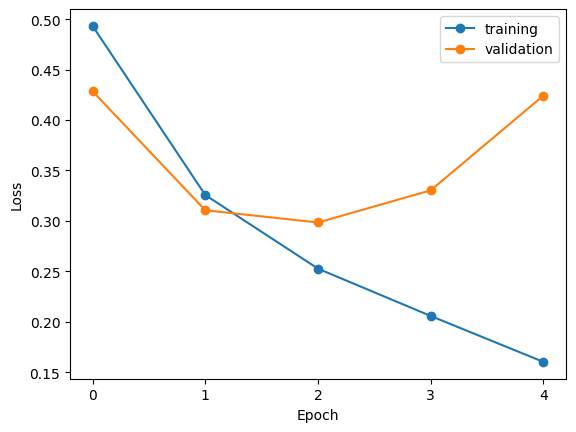

In [18]:
history_df = pd.DataFrame(history_no_aug.history)
plot_history(history_df)

In [19]:
preds = model_no_aug.predict(valid_ds)

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step


In [20]:
val_preds = np.rint(preds)[:,1]

print('val accuracy:',accuracy_score(valid_labels,val_preds))
print('val f1:',f1_score(valid_labels,val_preds))

val accuracy: 0.8578610603290676
val f1: 0.6548279689234183


# Basic Augmentation

In [20]:
train_basic_aug_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size, cutout=True, cache=True)


In [21]:
# Build Classifier
model_base_aug = keras_cv.models.ImageClassifier.from_preset(
    CFG.preset, num_classes=CFG.num_classes, activation="sigmoid"
)

# Compile the model  
model_base_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
model_base_aug.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │         2,818 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,772,192 (33.46 MB)

 Trainable params: 8,689,904 (33.15 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [22]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [23]:
history_base_aug = model_base_aug.fit(
    train_basic_aug_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/5


I0000 00:00:1713037409.594165     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 279s 669ms/step - loss: 0.5565 - val_loss: 0.4189 - learning_rate: 5.0000e-05
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 505ms/step - loss: 0.3493 - val_loss: 0.2975 - learning_rate: 1.6133e-04
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 70s 507ms/step - loss: 0.2653 - val_loss: 0.2744 - learning_rate: 2.7267e-04
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 495ms/step - loss: 0.2274 - val_loss: 0.3187 - learning_rate: 3.8400e-04
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 496ms/step - loss: 0.1645 - val_loss: 0.3444 - learning_rate: 3.7485e-04


In [24]:
preds = model_base_aug.predict(valid_ds)
val_preds = np.rint(preds)[:,1]

print('val accuracy:',accuracy_score(valid_labels,val_preds))
print('val f1:',f1_score(valid_labels,val_preds))

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step
val accuracy: 0.8743144424131627
val f1: 0.6947835738068813


In [25]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

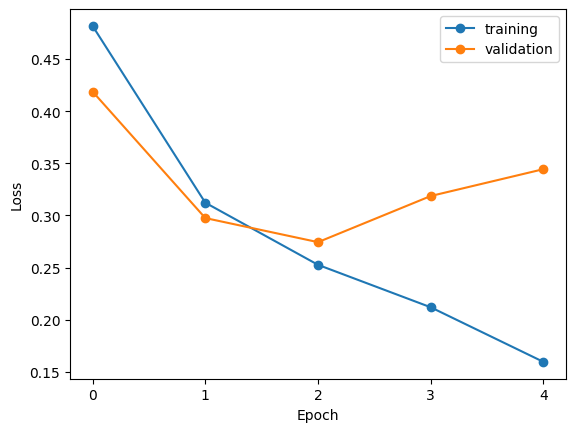

In [26]:
history_df = pd.DataFrame(history_base_aug.history)
plot_history(history_df)

#### *Augmentation Hyperparameters*:

| Training Loss | Validation Loss |  Accuracy |  F1 Precision | crop  |  rotation | contrast  | noise | mixup | cutout  | brightness | flip | zoom| translation|
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:              |:-:         |:-:                 |:-:               |:-:             |:-:                  |:-:                  |:-:                  |:-:                  |
| 0.167              | 0.424                | 0.858          | 0.655      | no        | no          | no       | no                | no                | no            | no            | no            | no            | no            | no            | no            | no            | no            |
| 0.167              | 0.442                | 0.853          | 0.668      | yes        | yes          | yes       | yes                | yes                | yes            | yes            | yes            | yes            | yes            |
| 0.177               | 0.331                 | 0.874     | 0.679      | <font color="red">yes</font>        | no          | no       | no                | no                | no            | no            | no            | no            | no            |
| 0.173               | 0.336                 | 0.891          | 0.675      | no        | <font color="red">yes</font>       | no       | no                | no                | no            | no            | no            | no            | no            |
| 0.170               | 0.308                 | 0.885          | 0.667      | no        | no          |<font color="red">yes</font>     | no                | no                | no            | no            | no            | no            | no            |
| 0.173               | 0.324                 | 0.884          | 0.679      | no        | no          | no       | <font color="red">yes</font>            | no                | no            | no            | no            | no            | no            |
| 0.172               | 0.310                 | 0.889          | 0.674      |no        | no          | no       | no                | <font color="red">yes</font>            | no            | no            | no            | no            | no            |
| 0.165               | 0.344                 | 0.874          | 0.695      | no        | no          | no       | no                | no                | <font color="red">yes</font>         | no            | no            | no            | no           |
| 0.0               | 0.0                 | 0          | 0      | no        | no          | no       | no                | no                | no         | <font color="red">yes</font>            | no            | no            | no            |
| 0.0               | 0.0                 | 0          | 0      | no        | no          | no       | no                | no                | no         | no            | <font color="red">yes</font>            | no            | no            |
| 0.0               | 0.0                 | 0          | 0      | no        | no          | no       | no                | no                | no         | no            | no            | <font color="red">yes</font>            | no            |
| 0.0               | 0.0                 | 0          | 0      | no        | no          | no       | no                | no                | no         | no            | no            | no            | <font color="red">yes</font>            |


